In [1]:
import numpy as np
import os
import random as python_random
from keras.datasets import boston_housing
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import keras_tuner as kt
from keras_tuner import Objective
import tensorflow as tf
import tensorflow_addons as tfa
from keras.metrics import RootMeanSquaredError
from tensorflow_addons.metrics import RSquare
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from scipy.spatial.distance import pdist
from keras.initializers import Initializer
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K



def set_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_CUDNN_DETERMINISTIC"] = str(seed)

    # source: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    # source: https://github.com/keras-team/keras/issues/2743
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)


2023-03-02 02:08:11.636114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 02:08:11.829359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 02:08:11.829402: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-02 02:08:12.935237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:

# Helpers
# plot learning curves
def plot_history(history):
    epochs = len(history.history["accuracy"])
    x = np.arange(1, epochs + 1)
    plt.figure(constrained_layout=True)
    plt.subplot(211)
    plt.plot(x, history.history["r_square"])
    plt.plot(x, history.history["val_r_square"], color="green")
    plt.legend(["train", "validation"], loc="upper left")

    plt.subplot(211)
    plt.plot(x, history.history["r_square"])
    plt.plot(x, history.history["val_r_square"], color="green")
    plt.ylabel("r2")
    plt.legend(["train", "validation"], loc="upper left")


    plt.subplot(212)
    plt.plot(x, history.history["loss"])
    plt.plot(x, history.history["val_loss"], color="green")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "validation"], loc="upper right")



In [3]:

# the feature B isn't included to avoid ethnical problems
# source: https://keras.io/api/datasets/boston_housing/
(train_x, train_y), (test_x, test_y) = boston_housing.load_data(test_split=0.25)

num_samples, num_features = train_x.shape

# z-score normalization
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)



Neurons 37


2023-03-02 02:08:15.609130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-02 02:08:15.609166: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 02:08:15.609188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thodkatz-hp): /proc/driver/nvidia/version does not exist
2023-03-02 02:08:15.609412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: Future

Epoch 1/100
10/10 [==============================] - 2s 59ms/step - loss: 515.4175 - accuracy: 0.0000e+00 - root_mean_squared_error: 22.7028 - r_square: -5.6432 - val_loss: 677.5417 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 26.0296 - val_r_square: -4.9425
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 433.3701 - accuracy: 0.0000e+00 - root_mean_squared_error: 20.8175 - r_square: -4.5857 - val_loss: 561.4314 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 23.6945 - val_r_square: -3.9241
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 323.1649 - accuracy: 0.0000e+00 - root_mean_squared_error: 17.9768 - r_square: -3.1653 - val_loss: 411.9960 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 20.2977 - val_r_square: -2.6135
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 205.2196 - accuracy: 0.0000e+00 - root_mean_squared_error: 14.3255 - r_square: -1.6451 - val_loss: 277.0308 - 

/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/100
10/10 [==============================] - 1s 31ms/step - loss: 527.3986 - accuracy: 0.0000e+00 - root_mean_squared_error: 22.9652 - r_square: -5.7977 - val_loss: 701.9117 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 26.4936 - val_r_square: -5.1563
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 466.1275 - accuracy: 0.0000e+00 - root_mean_squared_error: 21.5900 - r_square: -5.0079 - val_loss: 616.1828 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 24.8230 - val_r_square: -4.4043
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 383.2701 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.5773 - r_square: -3.9400 - val_loss: 496.7643 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 22.2882 - val_r_square: -3.3570
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 277.7583 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.6661 - r_square: -2.5800 - val_loss: 356.1487 - val

/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/100
10/10 [==============================] - 1s 31ms/step - loss: 529.3385 - accuracy: 0.0000e+00 - root_mean_squared_error: 23.0074 - r_square: -5.8227 - val_loss: 706.1530 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 26.5735 - val_r_square: -5.1935
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 469.8209 - accuracy: 0.0000e+00 - root_mean_squared_error: 21.6754 - r_square: -5.0555 - val_loss: 623.5182 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 24.9703 - val_r_square: -4.4687
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 389.9076 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.7461 - r_square: -4.0255 - val_loss: 508.2514 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 22.5444 - val_r_square: -3.4577
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 286.9230 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.9388 - r_square: -2.6982 - val_loss: 369.5280 - val

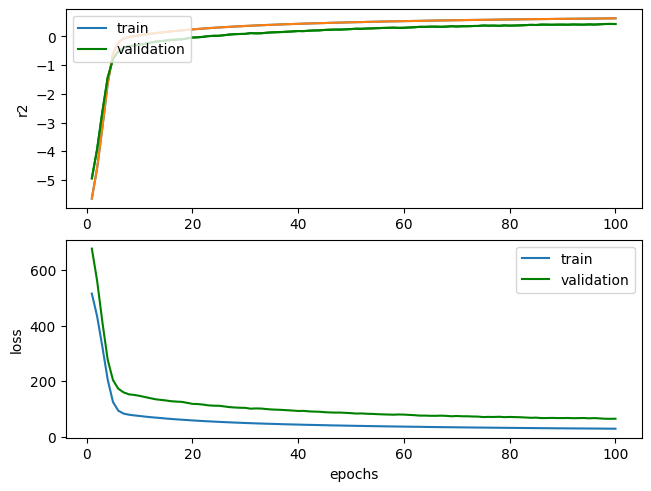

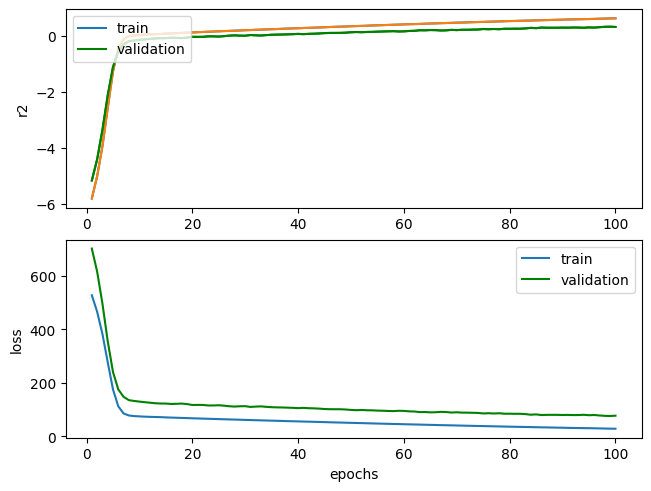

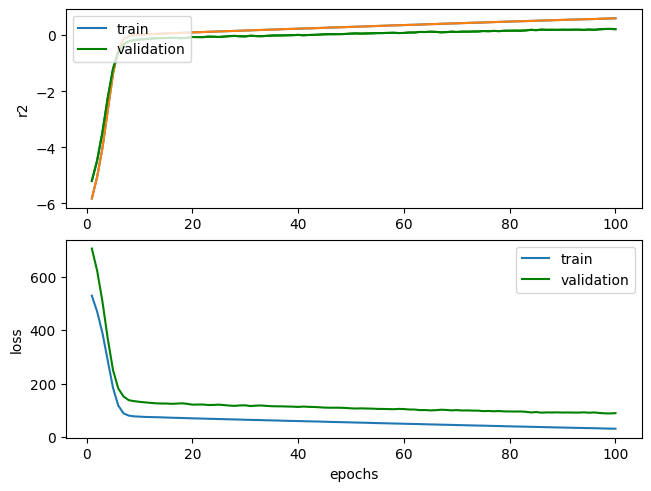

In [4]:

class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

class RBFWithKMeansLayer(Layer):
    def __init__(self, output_dim, train_data, **kwargs):
        self.output_dim = output_dim
        self.initializer = InitCentersKMeans(train_data)
        super(RBFWithKMeansLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=False)
        max_dist = max(pdist(self.centers))
        sigma = max_dist / np.sqrt(2 * self.output_dim)
        self.gamma = 1/(2*(sigma**2))
        super(RBFWithKMeansLayer, self).build(input_shape)

    def call(self, x):
        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.gamma * K.sum(H**2, axis=1))


def rbf_model(num_neurons):
    model = Sequential()
    model.add(RBFWithKMeansLayer(num_neurons, train_data=train_x, input_shape=(num_features,)))
    model.add(Dense(128))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.001), 
                  loss="mse", 
                  metrics=["accuracy", RootMeanSquaredError(), RSquare()])
    return model

def fit(model):
    return model.fit(train_x, train_y, batch_size=32, epochs=100, validation_split=0.2)


hidden_neurons = [int(0.1*num_samples), int(0.5*num_samples), int(0.9*num_samples)]
for neurons in hidden_neurons:
    set_seed(1)
    print("Neurons", neurons)
    model = rbf_model(neurons)
    plot_history(fit(model))
    print("Evaluation", model.evaluate(test_x, test_y))



INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
rbf_neurons: 56
hidden_layer_nodes: 128
dropout_prob: 0.35
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 7.875191688537598
Trial summary
Hyperparameters:
rbf_neurons: 56
hidden_layer_nodes: 256
dropout_prob: 0.35
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0230
Score: 7.890896320343018
Trial summary
Hyperparameters:
rbf_neurons: 18
hidden_layer_nodes: 128
dropout_prob: 0.5
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 7.910417079925537
Trial summary
Hyperparameters:
rbf_neurons: 56
hidden_layer_nodes: 256
dropout_prob: 0.2
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0203
Score: 7.924595832824707
Trial summary
Hyperparameters:
rbf_neurons: 56
hidden_l

/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 1s 28ms/step - loss: 26.7316 - accuracy: 0.0000e+00 - root_mean_squared_error: 5.1703 - r_square: 0.6555 - val_loss: 63.6753 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 7.9797 - val_r_square: 0.4415
Epoch 2/1000
10/10 [==============================] - 0s 6ms/step - loss: 28.5396 - accuracy: 0.0000e+00 - root_mean_squared_error: 5.3422 - r_square: 0.6322 - val_loss: 62.4848 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 7.9047 - val_r_square: 0.4520
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 29.1910 - accuracy: 0.0000e+00 - root_mean_squared_error: 5.4029 - r_square: 0.6238 - val_loss: 62.4460 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 7.9023 - val_r_square: 0.4523
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 25.6415 - accuracy: 0.0000e+00 - root_mean_squared_error: 5.0637 - r_square: 0.6695 - val_loss: 63.7892 - val_accuracy: 0.0000e

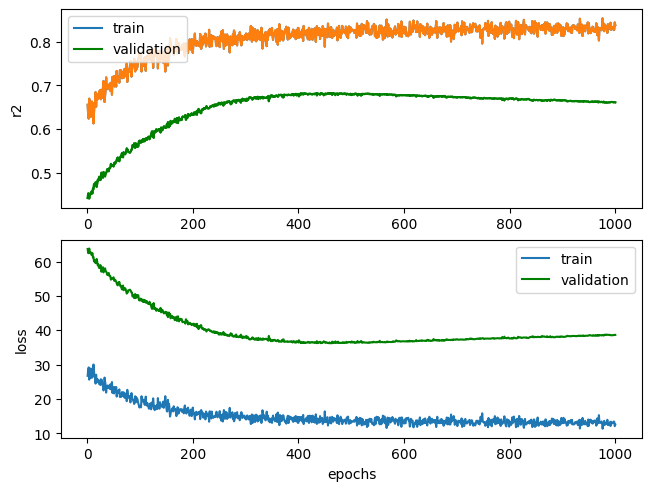

In [5]:

#Fine tuning

def build_model(hp):
    rbf_neurons = hp.Choice("rbf_neurons", values=[int(0.05*num_samples), int(0.15*num_samples), int(0.3*num_samples), int(0.5*num_samples)])
    hidden_layer_nodes = hp.Choice("hidden_layer_nodes", values=[32, 64, 128, 256])
    dropout_prob = hp.Choice("dropout_prob", values=[0.2, 0.35, 0.5])
    model = Sequential()
    model.add(RBFWithKMeansLayer(rbf_neurons, train_data=train_x, input_shape=(num_features,)))
    model.add(Dense(hidden_layer_nodes))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.001), 
                  loss="mse", 
                  metrics=["accuracy", RootMeanSquaredError(), RSquare()])
    return model


build_model(kt.HyperParameters())

tuner = kt.Hyperband(hypermodel=build_model, objective=Objective("val_root_mean_squared_error", direction='min'))
tuner.search(
    train_x,
    train_y,
    validation_split=0.2,
    epochs=100,
)
tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(train_x, train_y, epochs=200, validation_split=0.2)
loss_val, accuracy_val, rmse, r2 = best_model.evaluate(test_x, test_y)

print("loss:" + str(loss_val))
print("accuracy:" + str(accuracy_val))
print("rmse:" + str(rmse))
print("r2:" + str(r2))

# learning curves
plot_history(history)
